In [38]:
# data wrangling/viz libs
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm
# preprocessing libs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# modelling libs
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

pd.set_option('display.max_columns', None)


# Load Dataset

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')


# Explaratory Data Analysis

Goals:
* Visualize various features: distribution, covariance w/ target feature
* Observe missing features

### EDA: Target Feature Exploration

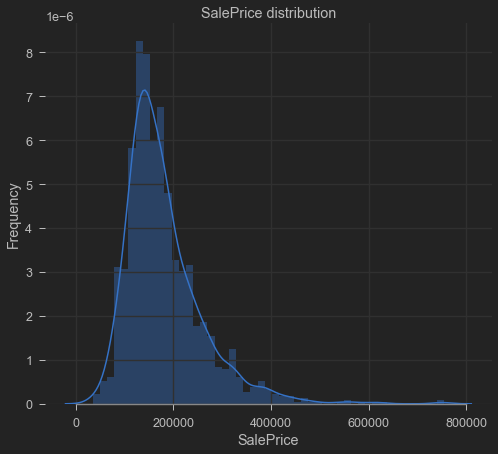

Skewness: 1.882876
Kurtosis: 6.536282


In [3]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.grid(True)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

### EDA: Feature Correlation w/ Target Feature

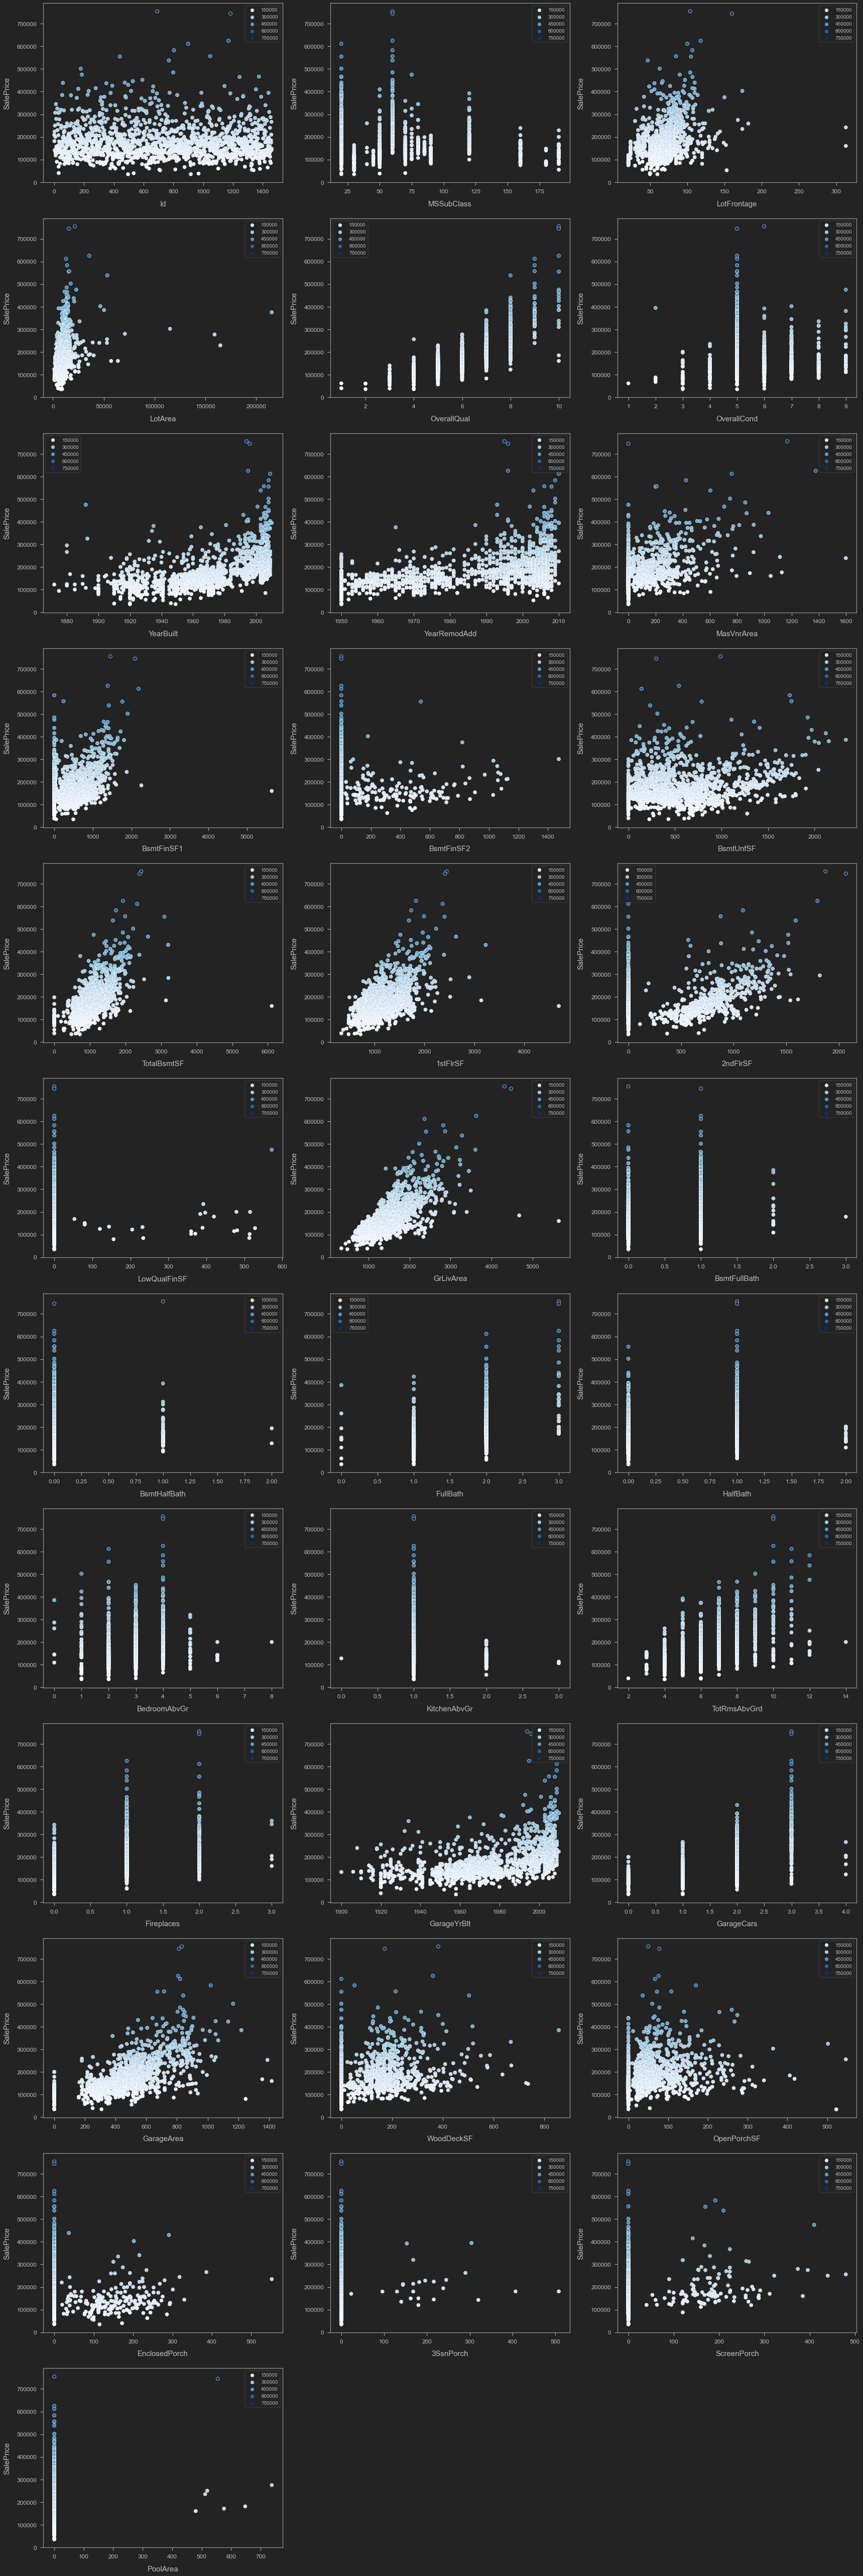

In [4]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()


### EDA: Visual Feature Correlation

<AxesSubplot:>

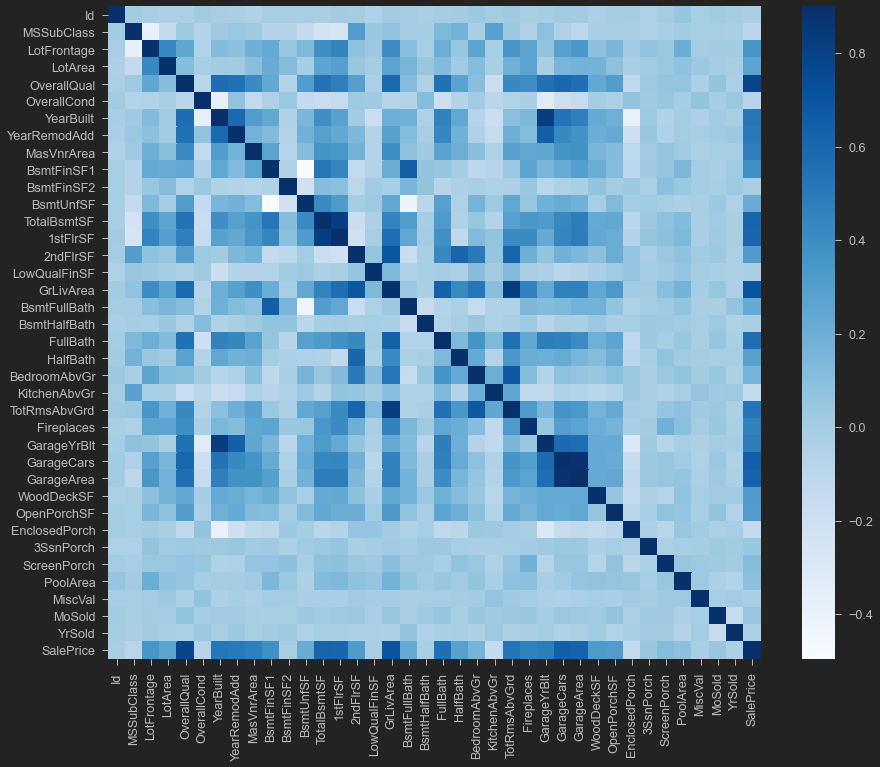

In [5]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

### EDA: Target Feature Relation to Support Features

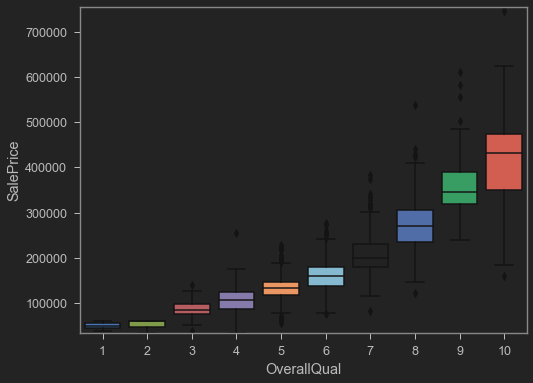

In [6]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=train['SalePrice'].min(), ymax=train['SalePrice'].max());
plt.show()


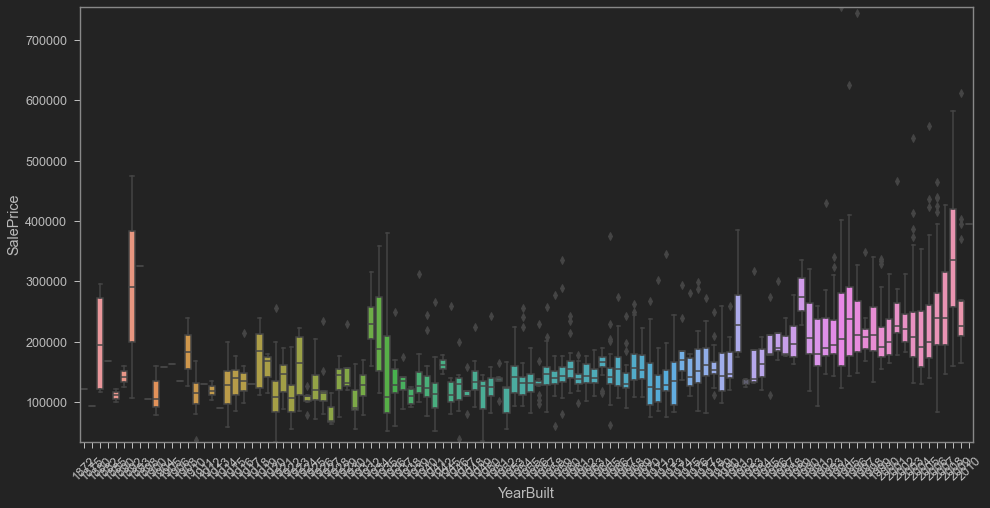

In [7]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=train['SalePrice'].min(), ymax=train['SalePrice'].max());
plt.xticks(rotation=45);


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

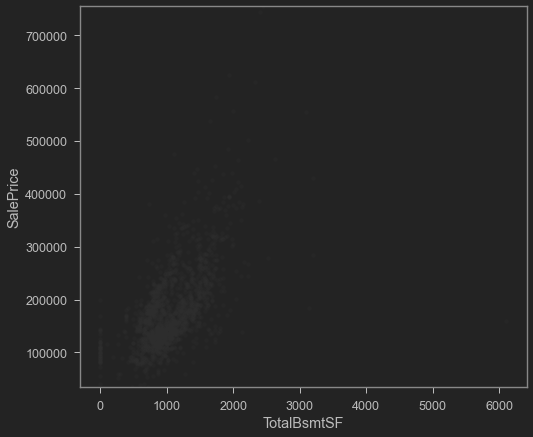

In [8]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', 
                  alpha=0.3, 
                  ylim=(train['SalePrice'].min(),train['SalePrice'].max()))


<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

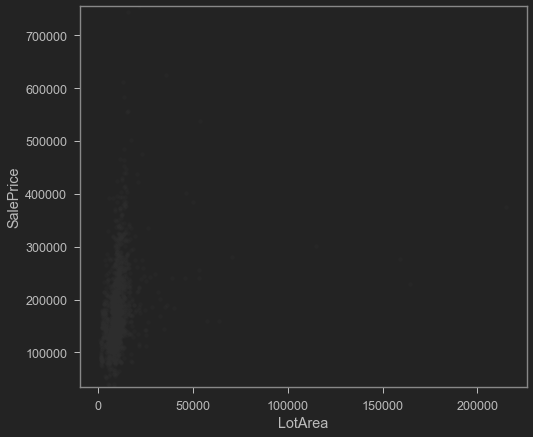

In [9]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, 
                  ylim=(train['SalePrice'].min(),train['SalePrice'].max()))


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

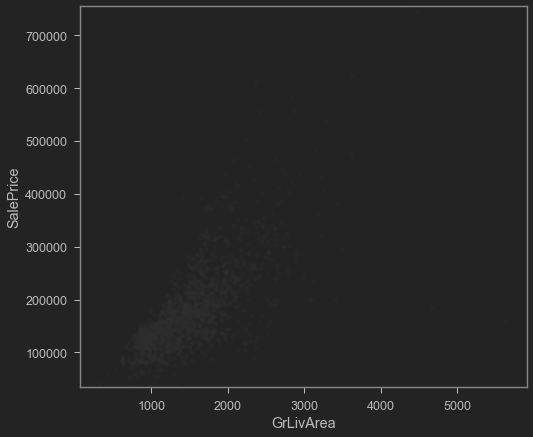

In [10]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, 
                  ylim=(train['SalePrice'].min(),train['SalePrice'].max()))


In [11]:
data = pd.concat((train, test)).reset_index(drop=True)

# Feature Engineering (FE) & Imputation

In [12]:
# combine both train and test for preprocessing
train_test=pd.concat([train,test],axis=0,sort=False)
train_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [13]:
pd.set_option('display.max_rows', 5000)
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_tes_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_tes_info

,Count of NaN,DataTypes
Id,0,int64
MSSubClass,0,int64
MSZoning,4,object
LotFrontage,486,float64
LotArea,0,int64
Street,0,object
Alley,2721,object
LotShape,0,object
LandContour,0,object
Utilities,2,object


### FE: Target Feature (Dependent Variable)

In [14]:
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train['SalePrice'], color="b");
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel="SalePrice")
# ax.set(title="SalePrice distribution")
# sns.despine(trim=True, left=True)
# plt.grid(True)
# plt.show()

# print("Skewness: %f" % train['SalePrice'].skew())
# print("Kurtosis: %f" % train['SalePrice'].kurt())

In [15]:
# # normalize target feature
# train["SalePrice"] = np.log1p(train["SalePrice"])

# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train['SalePrice'], color="b");
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel="SalePrice")
# ax.set(title="SalePrice distribution")
# sns.despine(trim=True, left=True)
# plt.grid(True)
# plt.show()

# print("Skewness: %f" % train['SalePrice'].skew())
# print("Kurtosis: %f" % train['SalePrice'].kurt())


### FE: Support Features (Independent Variables)

In [16]:
# # useful function for observing features containing missing values
# # ref: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
# # determine the threshold for missing values
# def percent_missing(df):
#     data = pd.DataFrame(df)
#     df_cols = list(pd.DataFrame(data))
#     dict_x = {}
#     for i in range(0, len(df_cols)):
#         dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
#     return dict_x

# missing = percent_missing(data)
# df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
# print('Percent of missing data')
# df_miss[0:10]


In [17]:
# # Visualize missing values
# # sns.set_style("white")
# f, ax = plt.subplots(figsize=(8, 7))
# # sns.set_color_codes(palette='deep')
# missing = round(train.isnull().mean()*100,2)
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)
# missing.plot.bar(color="b")
# # Tweak the visual presentation
# ax.xaxis.grid(False)
# ax.set(ylabel="Percent of missing values")
# ax.set(xlabel="Features")
# ax.set(title="Percent missing data by feature")
# sns.despine(trim=True, left=True)


### FE: FillNA

In [18]:
train_test.loc[train_test['Fireplaces']==0,'FireplaceQu']='Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear',inplace=True)
train_test['LotFrontage']=train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear',inplace=True)
train_test['MasVnrArea']=train_test['MasVnrArea'].astype(int)
train_test["Fence"] = train_test["Fence"].fillna("None")
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None")
train_test.loc[train_test['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
train_test.loc[train_test['BsmtFinSF2']==0,'BsmtQual']='TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

for i in train_test.columns:
    if 'SalePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)]=train_test[str(i)].fillna(method='ffill')


In [19]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

In [20]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

MiscVal              21.947195
PoolArea             16.898328
exists_pool          14.884318
LotArea              12.822431
LowQualFinSF         12.088761
3SsnPorch            11.376065
LandSlope             4.975157
KitchenAbvGr          4.302254
EnclosedPorch         4.003891
ScreenPorch           3.946694
MasVnrArea            2.600375
OpenPorchSF           2.535114
WoodDeckSF            1.842433
LotFrontage           1.483631
1stFlrSF              1.469604
Total_Porch_Area      1.376649
GrLivArea             1.269358
2ndFlrSF              0.861675
TotRmsAbvGrd          0.758367
MSSubClass            0.738722
Fireplaces            0.733495
HalfBath              0.694566
OverallCond           0.570312
HeatingQC             0.486656
FireplaceQu           0.333787
BedroomAbvGr          0.326324
OverallQual           0.197110
MoSold                0.195884
FullBath              0.167606
YrSold                0.132399
Id                    0.000000
exists_fireplace     -0.054148
BsmtFinT

In [21]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [22]:
print(high_skewness)
print('\nVariables with high skewness: \n\n',skewed_features)

MiscVal             21.947195
PoolArea            16.898328
exists_pool         14.884318
LotArea             12.822431
LowQualFinSF        12.088761
3SsnPorch           11.376065
LandSlope            4.975157
KitchenAbvGr         4.302254
EnclosedPorch        4.003891
ScreenPorch          3.946694
MasVnrArea           2.600375
OpenPorchSF          2.535114
WoodDeckSF           1.842433
LotFrontage          1.483631
1stFlrSF             1.469604
Total_Porch_Area     1.376649
GrLivArea            1.269358
BsmtExposure        -1.176341
KitchenQual         -1.448023
ExterQual           -1.801409
Fence               -1.993777
ExterCond           -2.497719
PavedDrive          -2.979084
BsmtCond            -3.301446
BsmtFinType2        -3.412861
CentralAir          -3.459022
GarageQual          -3.919880
exists_garage       -3.941054
Functional          -4.055757
GarageCond          -5.147262
exists_bsmt         -5.828995
BsmtQual            -6.303596
Street             -15.500133
PoolQC    

In [23]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

,MiscVal,PoolArea,exists_pool,LotArea,LowQualFinSF,3SsnPorch,LandSlope,KitchenAbvGr,EnclosedPorch,ScreenPorch,MasVnrArea,OpenPorchSF,WoodDeckSF,LotFrontage,1stFlrSF,Total_Porch_Area,GrLivArea,BsmtExposure,KitchenQual,ExterQual,Fence,ExterCond,PavedDrive,BsmtCond,BsmtFinType2,CentralAir,GarageQual,exists_garage,Functional,GarageCond,exists_bsmt,BsmtQual,Street,PoolQC
0,0,0,0,8450,0,0,0,1,0,0,196,61,0,65,856,61,1710,3,2,2,4,4,2,3,5,1,4,1,6,4,1,3,1,3
1,0,0,0,9600,0,0,0,1,0,0,0,0,298,80,1262,298,1262,1,3,3,4,4,2,3,5,1,4,1,6,4,1,3,1,3
2,0,0,0,11250,0,0,0,1,0,0,162,42,0,68,920,42,1786,2,2,2,4,4,2,3,5,1,4,1,6,4,1,3,1,3
3,0,0,0,9550,0,0,0,1,272,0,0,35,0,60,961,307,1717,3,2,3,4,4,2,1,5,1,4,1,6,4,1,3,1,3
4,0,0,0,14260,0,0,0,1,0,0,350,84,192,84,1145,276,2198,0,2,2,4,4,2,3,5,1,4,1,6,4,1,3,1,3


In [24]:
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))


In [25]:
train_test=pd.get_dummies(train_test,dtype='int8')

In [26]:
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_test_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_test_info

,Count of NaN,DataTypes
Id,0,int64
MSSubClass,0,int64
LotFrontage,0,float64
LotArea,0,float64
Street,0,float64
Alley,0,int64
LotShape,0,int64
LandSlope,0,float64
OverallQual,0,int64
OverallCond,0,int64


# Post-FE: EDA Again

In [27]:
# split combined datasets into train & test
train=train_test[0:1460]
test=train_test[1460:2919]

In [28]:
train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

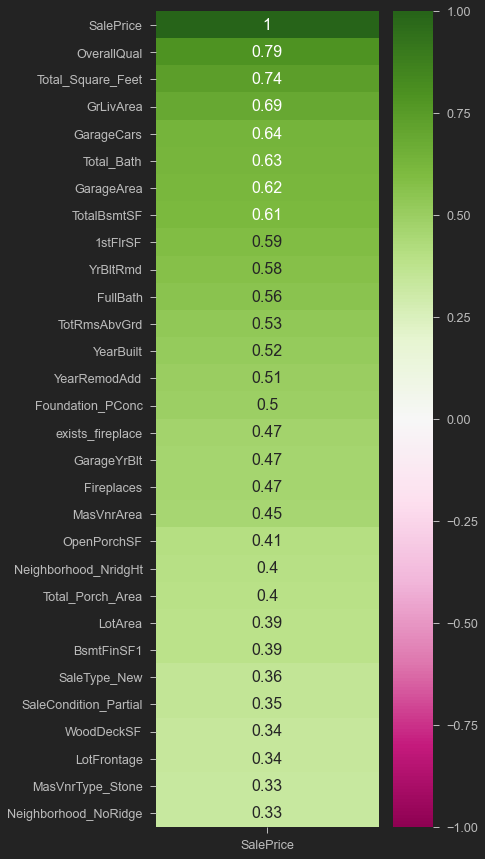

In [29]:
# visualize best correolation rates
corr_new_train=train.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sns.set(font_scale=2)

In [30]:
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
corr_dict2

{'SalePrice': 1.0,
 'OverallQual': 0.7909816005838047,
 'Total_Square_Feet': 0.7378811939482367,
 'GrLivArea': 0.6948427957824459,
 'GarageCars': 0.640409197258349,
 'Total_Bath': 0.6317310679319897,
 'GarageArea': 0.6234314389183598,
 'TotalBsmtSF': 0.6135805515591944,
 '1stFlrSF': 0.5885261491441507,
 'YrBltRmd': 0.5761444313502854,
 'FullBath': 0.5606637627484452,
 'TotRmsAbvGrd': 0.5337231555820238,
 'YearBuilt': 0.5228973328794967,
 'YearRemodAdd': 0.5071009671113867,
 'Foundation_PConc': 0.4977337525869438,
 'exists_fireplace': 0.4719080685164922,
 'GarageYrBlt': 0.46729002276453646,
 'Fireplaces': 0.4669288367515242,
 'MasVnrArea': 0.4549307960358911,
 'OpenPorchSF': 0.40653586761866684,
 'Neighborhood_NridgHt': 0.40214859817526666,
 'Total_Porch_Area': 0.3951689416199166,
 'LotArea': 0.3906209686442091,
 'BsmtFinSF1': 0.38641980624215627,
 'SaleType_New': 0.35750940508319695,
 'SaleCondition_Partial': 0.35205985467143425,
 'WoodDeckSF': 0.3376558485420904,
 'LotFrontage': 0.337

In [31]:
# visualize features w/ 40% positive or negation correlation w/ target feature
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        best_columns.append(key)
best_columns

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'old_house',
 'KitchenQual',
 'ExterQual']

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 [Text(1, 0, 'OverallQual'),
  Text(2, 0, 'Total_Square_Feet'),
  Text(3, 0, 'GrLivArea'),
  Text(4, 0, 'GarageCars'),
  Text(5, 0, 'Total_Bath'),
  Text(6, 0, 'GarageArea'),
  Text(7, 0, 'TotalBsmtSF'),
  Text(8, 0, '1stFlrSF'),
  Text(9, 0, 'YrBltRmd'),
  Text(10, 0, 'FullBath'),
  Text(11, 0, 'TotRmsAbvGrd'),
  Text(12, 0, 'YearBuilt'),
  Text(13, 0, 'YearRemodAdd'),
  Text(14, 0, 'Foundation_PConc'),
  Text(15, 0, 'exists_fireplace'),
  Text(16, 0, 'GarageYrBlt'),
  Text(17, 0, 'Fireplaces'),
  Text(18, 0, 'MasVnrArea'),
  Text(19, 0, 'OpenPorchSF'),
  Text(20, 0, 'Neighborhood_NridgHt'),
  Text(21, 0, 'Total_Porch_Area'),
  Text(22, 0, 'LotArea'),
  Text(23, 0, 'BsmtFinSF1'),
  Text(24, 0, 'SaleType_New'),
  Text(25, 0, 'SaleCondition_Partial'),
  Text(26, 0, 'WoodDeckSF'),
  Text(27, 0, 'LotFrontage'),
  

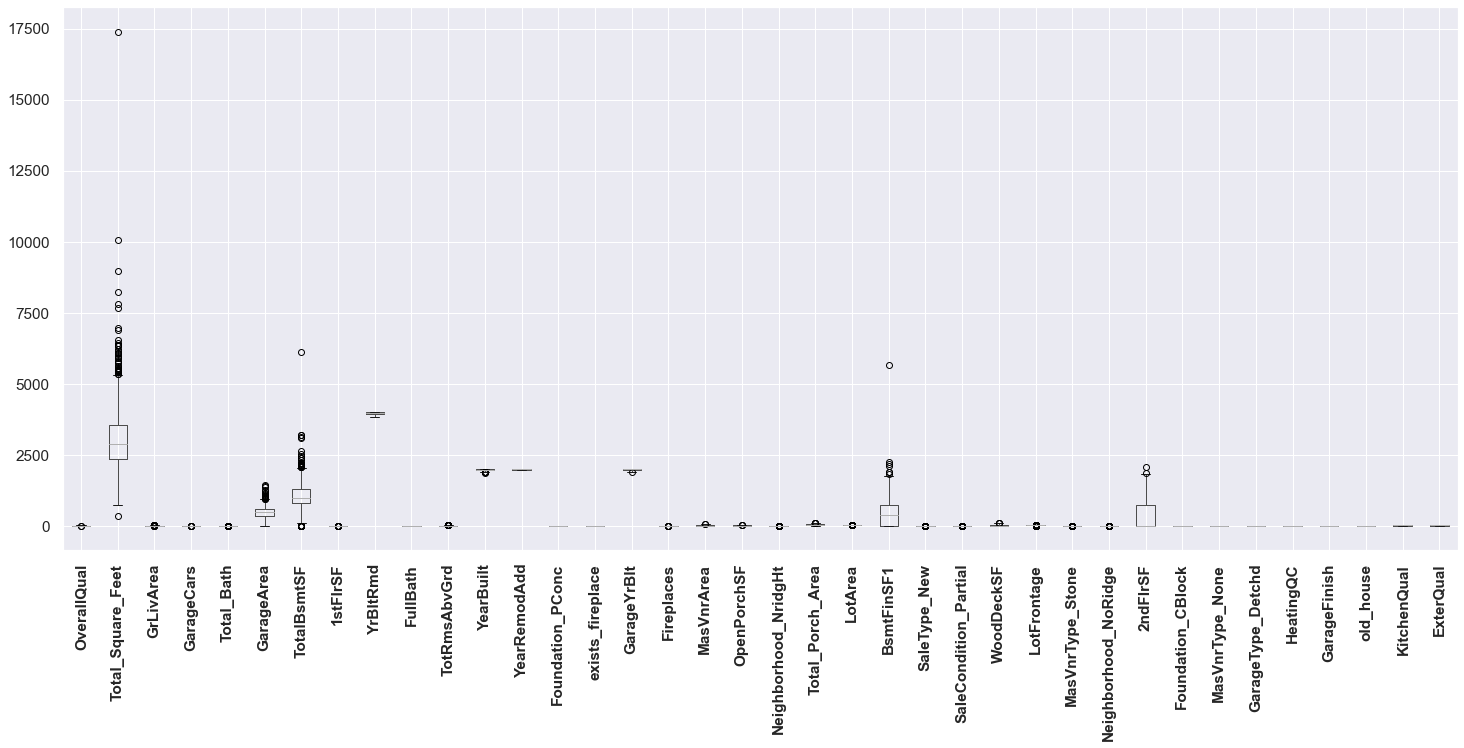

In [32]:
plt.figure(figsize=(25,10))
sns.set(font_scale=1.4)
train.boxplot(column=best_columns)
plt.xticks(weight='bold',rotation=90)

In [33]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)

Skew Dist: 1.8828757597682129
Kurtosis Dist: 6.536281860064529


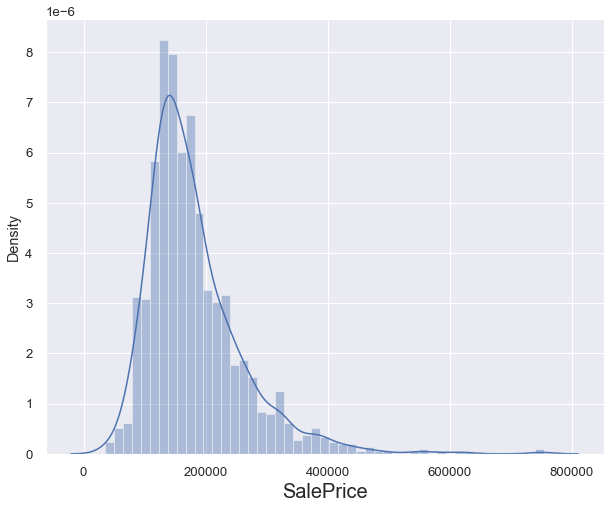

In [34]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
sns.distplot(train['SalePrice'])
plt.xlabel('SalePrice',fontsize=20)
print('Skew Dist:',train['SalePrice'].skew())
print('Kurtosis Dist:',train['SalePrice'].kurt())

Skew Dist: 0.12134661989685333
Kurtosis Dist: 0.809519155707878


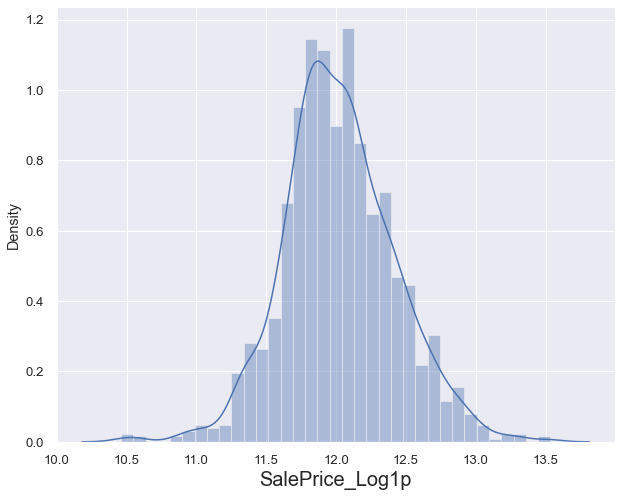

In [35]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
sns.distplot(train['SalePrice_Log1p'])
plt.xlabel('SalePrice_Log1p',fontsize=20)
print('Skew Dist:',train['SalePrice_Log1p'].skew())
print('Kurtosis Dist:',train['SalePrice_Log1p'].kurt())

### Post-FE: Cleaning Outliers

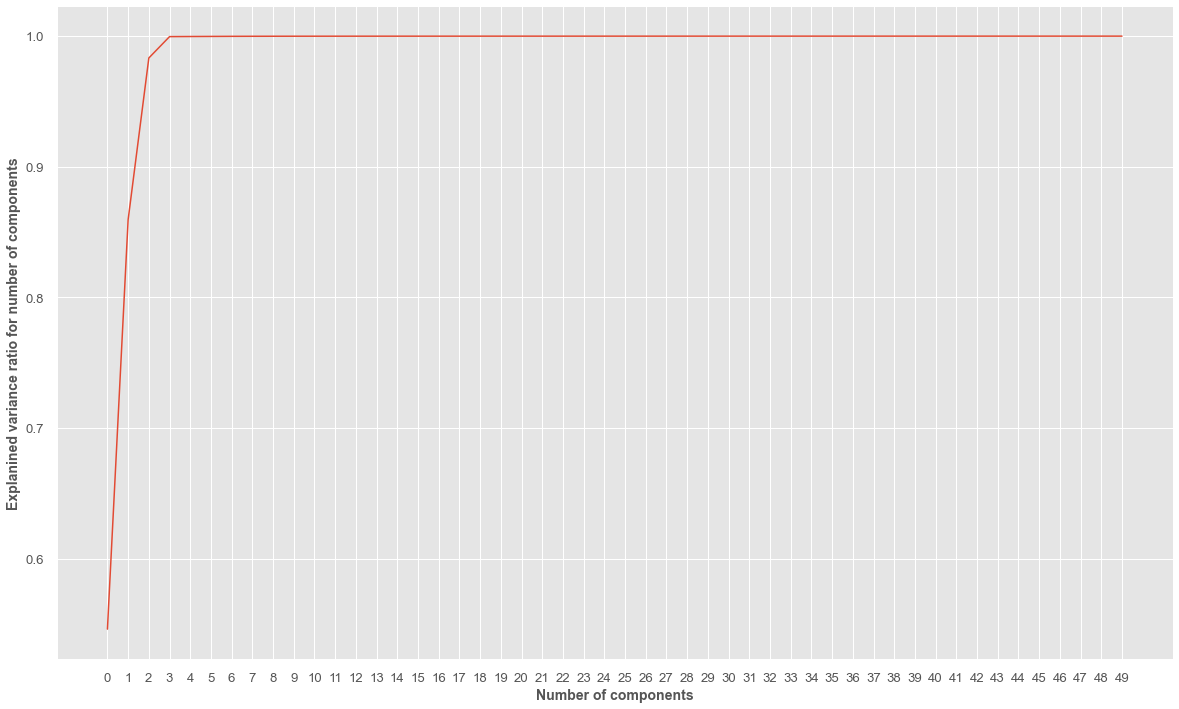

In [36]:
plt.style.use('ggplot')
plt.figure(figsize=(20,12))
rbst_scaler=RobustScaler()
train_rbst=rbst_scaler.fit_transform(train)

pca=PCA(50).fit(train_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of components',fontweight='bold',size=14)
plt.ylabel('Explanined variance ratio for number of components',fontweight='bold',size=14)

train_pca=PCA(3).fit_transform(train_rbst)

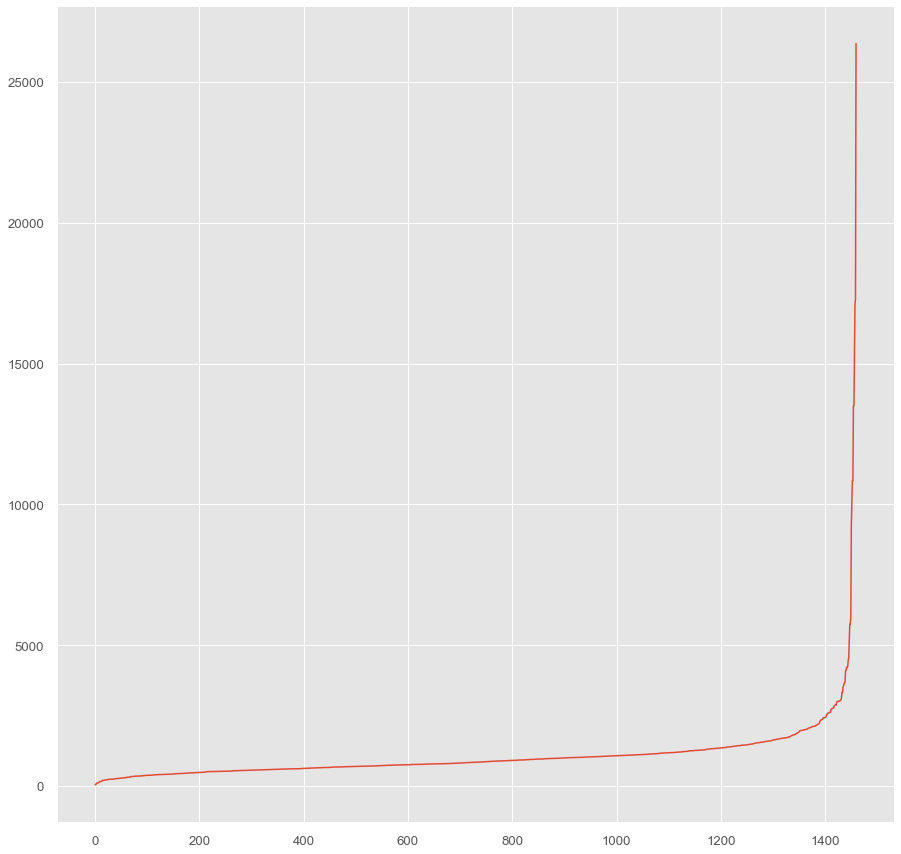

In [39]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,15))
plt.plot(distances)

In [ ]:
dbscan = DBSCAN(eps=1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [ ]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
labels=pd.DataFrame(labels,columns=['Classes'])
print(labels[labels['Classes']==-1])
train=pd.concat([train,labels],axis=1)
train[train.Classes==-1]

In [ ]:
train.drop([197,810,1170,1182,1298,1386,1423],axis=0,inplace=True)

In [ ]:
plt.style.use('dark_background')
fig, axes = plt.subplots(18, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [ ]:
"Looking at the SalePrice and SalePrice_Log1p visualizations"

#train = train.drop(train[(train.OverallQual==4) & (train.SalePrice>200000)].index)
#train = train.drop(train[(train.OverallQual==10) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_Square_Feet>=10000) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_SF<3000) & (train.SalePrice>375000)].index)
#train = train.drop(train[(train.GrLivArea>4500) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.GrLivArea<3000) & (train.SalePrice>575000)].index)
#train = train.drop(train[(train.GarageArea>1200) & (train.SalePrice<165000)].index)
#train = train.drop(train[(train.Total_Bath.isin([5,6])) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.TotRmsAbvGrd==10) & (train.SalePrice>700000)].index)
#train = train.drop(train[(train.YearBuilt<1900) & (train.SalePrice>250000)].index)
#train = train.drop(train[(train.YearBuilt>2000) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.YearRemodAdd<1970) & (train.SalePrice>350000)].index)
#train = train.drop(train[(train.MasVnrArea>=1400) & (train.SalePrice<250000)].index)
#train = train.drop(train[(train.GarageYrBlt<1960) & (train.SalePrice>340000)].index)
#train = train.drop(train[(train.Total_Porch_Area>600) & (train.SalePrice<50000)].index)
#train = train.drop(train[(train.LotFrontage>150) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.GarageFinish.isin([1,2])) & (train.SalePrice>470000)].index)
#train = train.drop(train[(train.old_house==0) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.old_house==1) & (train.SalePrice>400000)].index)
#train = train.drop(train[(train.KitchenQual==2) & (train.SalePrice>600000)].index)
#train = train.drop(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index)
#train = train.drop(train[(train.ExterQual==2) & (train.SalePrice>550000)].index)


train = train[train.GarageArea * train.GarageCars < 3700]
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

# Revisualize Correlations after Outlier Removal

In [ ]:
plt.style.use('dark_background')
corr1_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(25),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
del test['SalePrice']

# Encode Categorical Features

In [ ]:
data = pd.get_dummies(data, columns=col_cat)
data.drop(drop, axis=1, inplace=True)

# Recreate Training and Testing Sets

In [ ]:
X_train =  data[:-test_shape].drop(['SalePrice'], axis=1)
y_train =  data[:-test_shape]['SalePrice']
X_test  =  data[-test_shape:].drop(['SalePrice'], axis=1)
col_num = col_num.drop('SalePrice')

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[col_num] = scaler.fit_transform(X_train[col_num])
X_test[col_num]  = scaler.transform(X_test[col_num])


# Create Models

There are 2 parts to the regression:
1. Stacked Average of base algorithms and a meta algorithm
2. Blending of the Stacked Average with a gradient boosting algorithm (LightGBM)

In [ ]:
X=train.drop(['SalePrice','SalePrice_Log1p','Classes'],axis=1)
y=train.SalePrice_Log1p

In [ ]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(X)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)



model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

# Train Models

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))


In [ ]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))


In [ ]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
ensemble = stacked_pred*0.65 + lgb_pred*0.35

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
print(sub.head())